# 讀取資料

In [25]:
import pandas as pd
import numpy as np
import torch
data_path = "data/Bank_Personal_Loan_Modelling.csv"
raw_data = pd.read_csv(data_path)
data = raw_data
data

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


# 資料處理

## 欄位重新命名

In [26]:
data.rename(columns={"ZIP Code" : "ZIP_Code",
                     "Personal Loan":"Personal_Loan",
                     "Securities Account": "Securities_Account", 
                     "CD Account":"CD_Account"}, 
            inplace= True)
data = raw_data.drop(columns=['ID']) # 移除ID欄位
data = data.drop(columns=['ZIP_Code']) # 移除ZIP欄位

## Dummy variable

In [27]:
data['Education'] = data['Education'].astype('category')
data = pd.get_dummies(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   Family              5000 non-null   int64  
 4   CCAvg               5000 non-null   float64
 5   Mortgage            5000 non-null   int64  
 6   Personal_Loan       5000 non-null   int64  
 7   Securities_Account  5000 non-null   int64  
 8   CD_Account          5000 non-null   int64  
 9   Online              5000 non-null   int64  
 10  CreditCard          5000 non-null   int64  
 11  Education_1         5000 non-null   bool   
 12  Education_2         5000 non-null   bool   
 13  Education_3         5000 non-null   bool   
dtypes: bool(3), float64(1), int64(10)
memory usage: 444.5 KB


## 資料增強

In [28]:
Age_Exprience = data.Age * data.Experience
CCAvg_Personal_Loan = data.CCAvg * data.Personal_Loan   
CD_Account_Personal_Loan = data.CD_Account * data.Personal_Loan   

data.insert(10,"Age_Exprience",Age_Exprience)
data.insert(11,"CCAvg_Personal_Loan",CCAvg_Personal_Loan)
data.insert(12,"CD_Account_Personal_Loan",CD_Account_Personal_Loan)

## 視覺化

<Axes: >

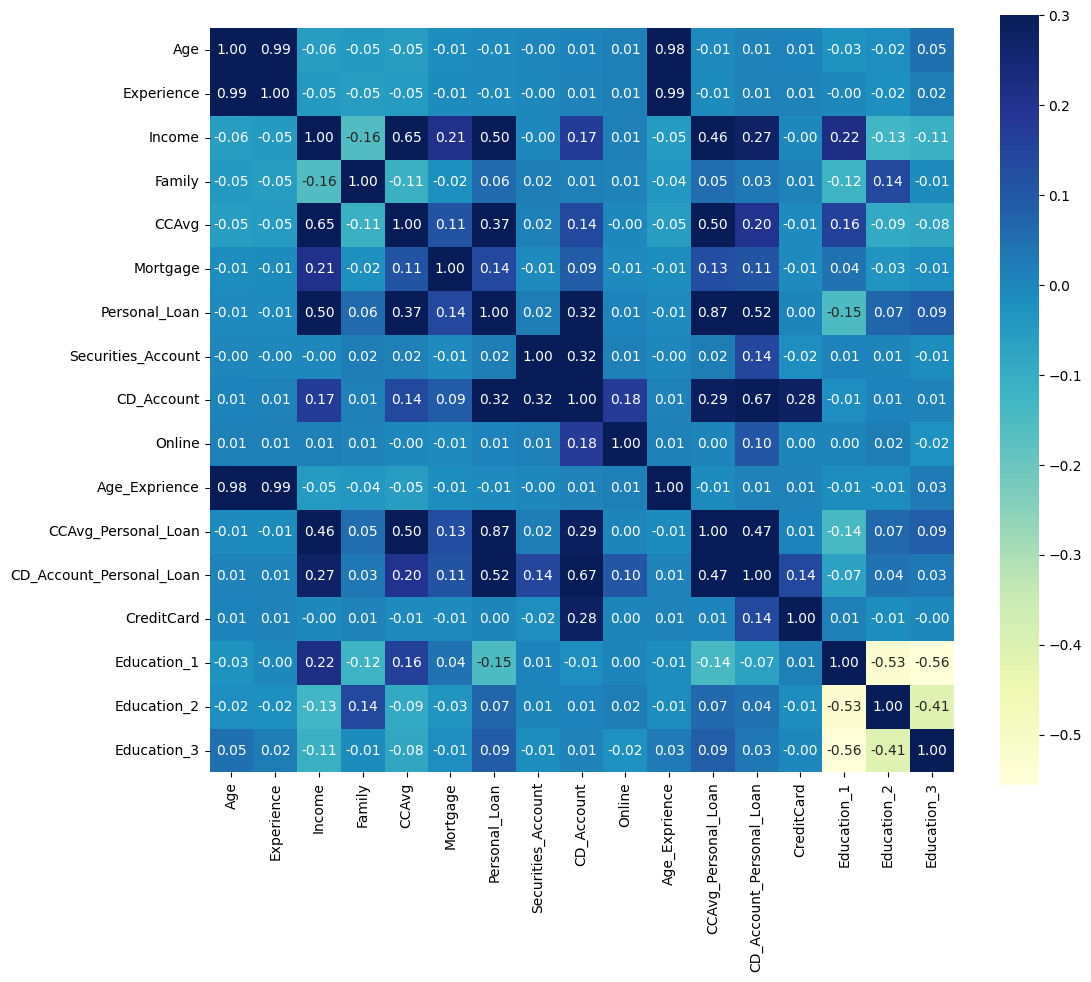

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu", square=True, fmt=".2f", vmax=.3)


## 分割資料

In [30]:
from sklearn.model_selection import train_test_split
data = data.astype('float')
X = torch.from_numpy(np.array(data.drop(columns=['Personal_Loan']))).type(torch.float)
y = torch.from_numpy(np.array(data['Personal_Loan'])).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE().fit_resample(X_train, y_train)
X_res = torch.from_numpy(X_res).type(torch.float)
y_res = torch.from_numpy(y_res).type(torch.float)


([<matplotlib.patches.Wedge at 0x21dc93bc490>,
 [Text(6.735557395310444e-17, 1.1, '0'),
  Text(-2.0206672185931328e-16, -1.1, '1')],
 [Text(3.6739403974420595e-17, 0.6, '50.0%\n( 3625 )'),
  Text(-1.1021821192326178e-16, -0.6, '50.0%\n( 3625 )')])

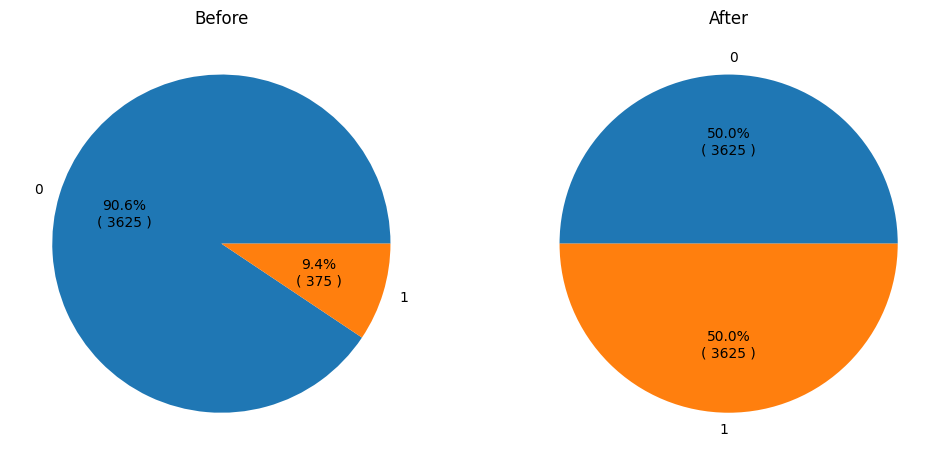

In [31]:
a = [0, 0]
for i in y_train:
    if i==0: a[0]+=1
    else: a[1]+=1
    
b = [0, 0]
for i in y_res:
    if i==0: b[0]+=1
    else: b[1]+=1

def func(s,d):
  t = int(round(s/100.*sum(d)))   
  return f'{s:.1f}%\n( {t} )'
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title('Before')
plt.pie(a, labels=[0,1], autopct=lambda i: func(i, a))
plt.subplot(1, 2, 2)
plt.title('After')
plt.pie(b, labels=[0,1], autopct=lambda i: func(i, b))

# 建立模型

In [32]:

from torch import nn
NUM_FEATURES = X_train.shape[1] # 變數個數
class LoanModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(LoanModelV0, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, hidden_units),
            # nn.ReLU(),
            # nn.Linear(hidden_units, hidden_units),
            # nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.linear_stack(x)
class LoanModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units_1, hidden_units_2, output_shape):
        super(LoanModelV1, self).__init__()
        self.stack_1 = nn.Sequential(
            nn.Linear(input_shape, hidden_units_1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units_1),
        )
        self.stack_2 = nn.Sequential(
            nn.Linear(hidden_units_1, hidden_units_2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units_2)
        )
        self.output = nn.Sequential(
            nn.Dropout(),
            nn.Linear(hidden_units_2, output_shape),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.stack_1(x)
        x = self.stack_2(x)
        x = self.output(x)
        return x
class LoanModelV2(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.layer_stake = nn.Sequential(
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, output_shape),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layer_stake(x)
model = LoanModelV2(NUM_FEATURES, 1)
model

LoanModelV2(
  (layer_stake): Sequential(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=16, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

# 訓練流程

In [33]:
from tqdm.auto import tqdm
def train_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    X, y,
    acc_fn
):
    model.to(device)
    model.train()
    y_logits = model(X).squeeze()
    y_pred = torch.round(y_logits)
    train_loss = loss_fn(y_logits, y)
    train_acc = acc_fn(y_pred, y)
    acc_fn.reset()
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    return train_loss, train_acc
def test_step(
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    device: torch.device,
    X, y,
    acc_fn
):
    model.to(device)
    model.eval()
    with torch.inference_mode():
        test_logits = model(X).squeeze()
        test_pred = torch.round(test_logits)
        test_loss = loss_fn(test_logits, y)
        test_acc = acc_fn(test_pred, y)
        acc_fn.reset()
    return test_loss, test_acc   
def train(model, train_X, train_y, test_X, test_y, loss_fn, acc_fn, optimizer, device, epochs):
    results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    model.to(device)
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = 0, 0
        test_loss, test_acc = 0, 0
        train_loss, train_acc = train_step(model, loss_fn, optimizer, device, train_X, train_y, acc_fn)
        test_loss, test_acc = test_step(model, loss_fn, device, test_X, test_y, acc_fn)
        results['train_loss'].append(train_loss.detach().numpy())
        results['train_acc'].append(train_acc.detach().numpy())
        results['test_loss'].append(test_loss.detach().numpy())
        results['test_acc'].append(test_acc.detach().numpy())
        if (epoch+1) % (epochs//10) == 0: 
            print(f"Epoch: {epoch+1}: train loss: {train_loss: .4f} | train accuracy: {train_acc: .4f} | test loss: {test_loss: .4f} | test accuracy: {test_acc: .4f}")
    return results

d:\python\Deep Learning\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 訓練模型

In [34]:
from torchmetrics import Accuracy
EPOCHS = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
loss_fn = nn.BCELoss()
acc_fn = Accuracy(task='binary')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# results = train(model, X_train, y_train, X_test, y_test, loss_fn, acc_fn, optimizer, device, EPOCHS)
results = train(model, X_res, y_res, X_test, y_test, loss_fn, acc_fn, optimizer, device, EPOCHS)

 15%|█▌        | 151/1000 [00:00<00:02, 287.46it/s]

Epoch: 100: train loss:  0.1000 | train accuracy:  0.9786 | test loss:  0.0800 | test accuracy:  0.9920


 25%|██▌       | 254/1000 [00:00<00:02, 323.88it/s]

Epoch: 200: train loss:  0.0558 | train accuracy:  0.9880 | test loss:  0.0468 | test accuracy:  0.9940


 32%|███▏      | 324/1000 [00:01<00:02, 310.91it/s]

Epoch: 300: train loss:  0.0396 | train accuracy:  0.9935 | test loss:  0.0345 | test accuracy:  0.9970


 43%|████▎     | 426/1000 [00:01<00:01, 315.07it/s]

Epoch: 400: train loss:  0.0311 | train accuracy:  0.9949 | test loss:  0.0281 | test accuracy:  0.9980


 53%|█████▎    | 526/1000 [00:01<00:01, 275.63it/s]

Epoch: 500: train loss:  0.0258 | train accuracy:  0.9963 | test loss:  0.0241 | test accuracy:  0.9980


 66%|██████▋   | 663/1000 [00:02<00:01, 318.48it/s]

Epoch: 600: train loss:  0.0222 | train accuracy:  0.9966 | test loss:  0.0213 | test accuracy:  0.9990


 70%|██████▉   | 696/1000 [00:02<00:01, 235.69it/s]

Epoch: 700: train loss:  0.0196 | train accuracy:  0.9967 | test loss:  0.0193 | test accuracy:  0.9990


 83%|████████▎ | 832/1000 [00:03<00:00, 243.08it/s]

Epoch: 800: train loss:  0.0176 | train accuracy:  0.9974 | test loss:  0.0178 | test accuracy:  0.9990


 96%|█████████▌| 956/1000 [00:03<00:00, 278.05it/s]

Epoch: 900: train loss:  0.0159 | train accuracy:  0.9975 | test loss:  0.0165 | test accuracy:  0.9990


100%|██████████| 1000/1000 [00:03<00:00, 261.55it/s]

Epoch: 1000: train loss:  0.0146 | train accuracy:  0.9977 | test loss:  0.0155 | test accuracy:  0.9990


# 損失&準確率視覺化

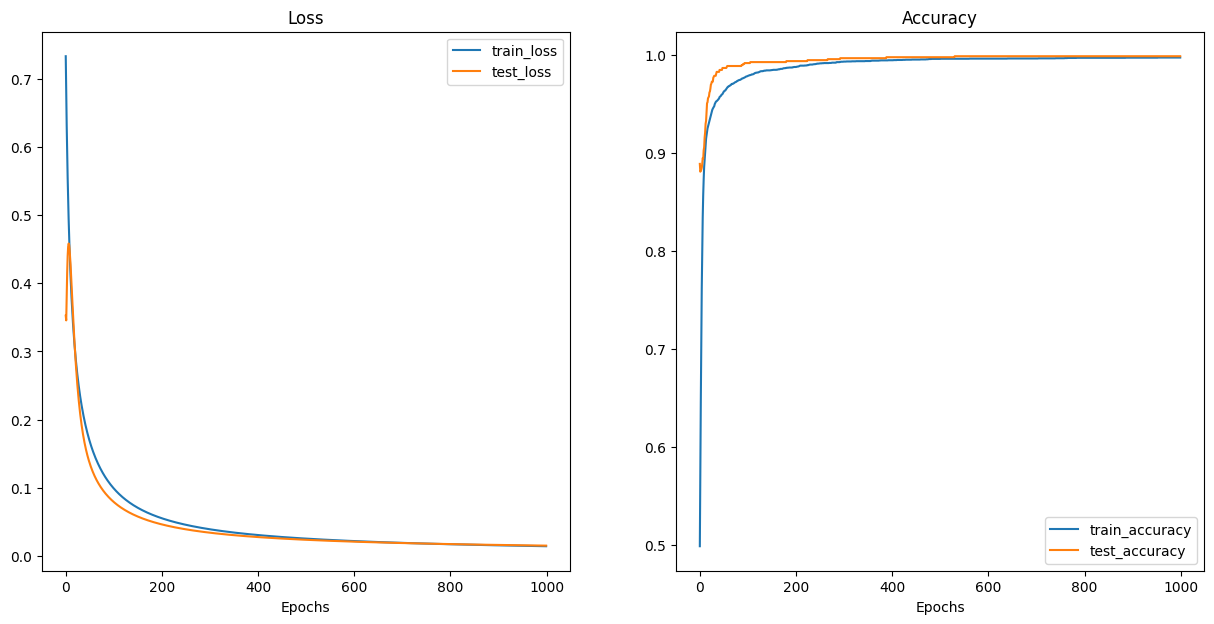

In [35]:
import matplotlib.pyplot as plt
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.
    """
    loss = results["train_loss"]
    
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
plot_loss_curves(results)

# 模型測試結果

In [36]:
def ModelTest(model, X_test):
    with torch.inference_mode():
        test_pred = torch.round(model(X_test))
    return test_pred

test_pred = ModelTest(model, X)

## Confusion matrix

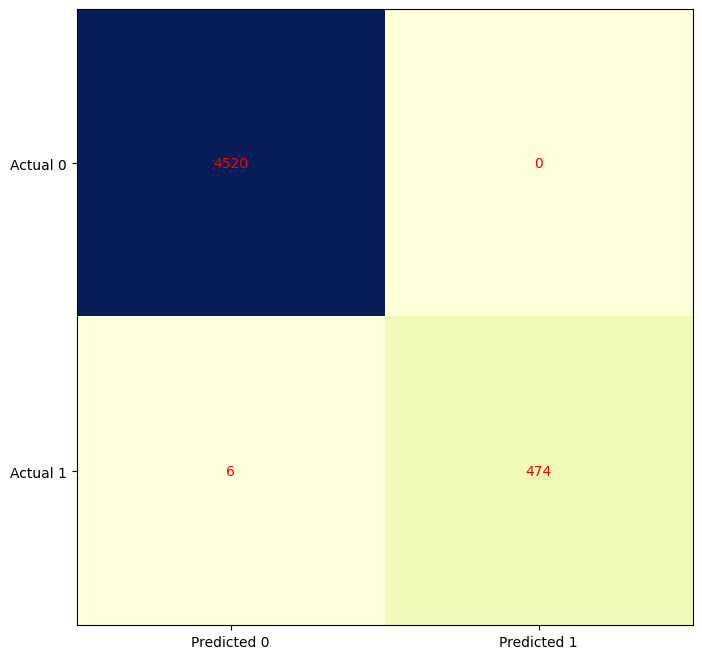

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np
CM = confusion_matrix(y, test_pred)
fig, ax = plt.subplots(figsize = (8, 8))
ax.imshow(CM, cmap="YlGnBu")
ax.grid(False)
ax.xaxis.set(ticks=(0,1), ticklabels=['Predicted 0', 'Predicted 1'])
ax.yaxis.set(ticks=(0,1), ticklabels=['Actual 0', 'Actual 1'])
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(i , j , CM[j, i],ha = "center", va = "center", color = "red")

In [38]:
from sklearn import metrics
print("Accuarcy", metrics.accuracy_score(y, test_pred))
print("ean_absolute_error",metrics.mean_absolute_error(y, test_pred))
print("Mean Squared Error",metrics.mean_squared_error(y, test_pred))
print("Root Mean Squared Error",np.sqrt(metrics.mean_squared_error(y, test_pred)))
print("R2_score",metrics.r2_score(y, test_pred))

Accuarcy 0.9988
ean_absolute_error 0.0012
Mean Squared Error 0.0012
Root Mean Squared Error 0.034641016
R2_score 0.9861725660989399


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y, ModelTest(model, X)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4520
         1.0       1.00      0.99      0.99       480

    accuracy                           1.00      5000
   macro avg       1.00      0.99      1.00      5000
weighted avg       1.00      1.00      1.00      5000



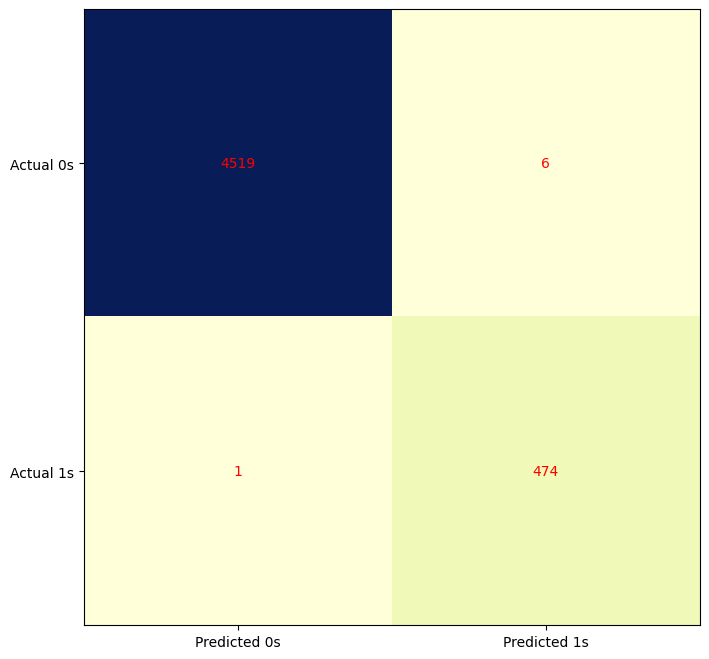

Accuarcy 0.9986
ean_absolute_error 0.0014
Mean Squared Error 0.0014
Root Mean Squared Error 0.037416574
R2_score 0.9838679937820964
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4520
         1.0       1.00      0.99      0.99       480

    accuracy                           1.00      5000
   macro avg       1.00      0.99      1.00      5000
weighted avg       1.00      1.00      1.00      5000



In [40]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver= "liblinear", C = X_train.shape[0])
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

cm = confusion_matrix(y, LR.predict(X))
fig, ax = plt.subplots(figsize = (8, 8))
ax.imshow(cm,cmap="YlGnBu")
ax.grid(False)
ax.xaxis.set(ticks= (0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks= (0, 1), ticklabels=("Actual 0s", "Actual 1s"))

ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(i , j , cm[i, j],ha = "center", va = "center", color = "red" )
plt.show()   

print("Accuarcy", metrics.accuracy_score(y, LR.predict(X)))
print("ean_absolute_error",metrics.mean_absolute_error(y, LR.predict(X)))
print("Mean Squared Error",metrics.mean_squared_error(y, LR.predict(X)))
print("Root Mean Squared Error",np.sqrt(metrics.mean_squared_error(y, LR.predict(X))))
print("R2_score",metrics.r2_score(y, LR.predict(X)))

print(classification_report(y, LR.predict(X)))